# Guía de Laboratorio

## Imports Necesarios

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from __future__ import annotations
from itertools import zip_longest

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate, SequentialSampler, RandomSampler, BatchSampler
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from typing import Mapping
from fastcore.test import test_close

In [55]:
import logging
logging.disable(logging.WARNING)

## Bases

In [56]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [57]:
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [58]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

In [59]:
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [60]:
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [61]:
class Optimizer():
    def __init__(self, params, lr=0.5): 
        #Hacemos los params list porque puede ser un generator, que recuerda
        #que es un iterable
        self.params = list(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [62]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    #El __getitem__ es lo que nos da los valores cuando hacemos por ejemplo 
    #Dataset[n:m]
    def __getitem__(self, i): return self.x[i],self.y[i]

In [63]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [64]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [65]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [66]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

### Funciones de Impresion de Imágenes

In [67]:
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [68]:
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

In [69]:
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

In [70]:
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [71]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'
mpl.rcParams['figure.dpi'] = 70

## Presentación de los Datos

In [72]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [73]:
ds_builder.info.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [74]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [75]:
x,y = 'image','label'
dsd = load_dataset(name)

In [76]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [77]:
batch_size = 256
transformed_dataset = dsd.with_transform(transformi)

In [78]:
transformed_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [79]:
transformed_dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

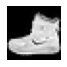

In [80]:
ds = transformed_dataset['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));

In [81]:
collate_function = collate_dict(ds)

In [82]:
def collate_(b): return to_device(collate_function(b))
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [83]:
dls = data_loaders(transformed_dataset, batch_size, collate_fn = collate_)

In [84]:
dls

{'train': <torch.utils.data.dataloader.DataLoader at 0x1e09add9ed0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1e0983fcf50>}

- `dt`: Data Loader Training
- `dv`: data Loader Validation

In [85]:
dt = dls['train']
dv = dls['test']

In [86]:
x_batch, y_batch = next(iter(dt))

In [87]:
x_batch.shape

torch.Size([256, 1, 28, 28])

In [88]:
y_batch.shape

torch.Size([256])

In [89]:
x_batch

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [90]:
y_batch

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5,
        9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1, 6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7,
        9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8, 8, 0, 1, 1, 6, 8, 1, 9, 7, 8, 8, 9, 6, 6, 3, 1, 5, 4, 6, 7, 5, 5, 9, 2, 2, 2, 7, 6, 4, 1, 8, 7,
        7, 5, 4, 2, 9, 1, 7, 4, 6, 9, 7, 1, 8, 7, 1, 2, 8, 0, 9, 1, 8, 7, 0, 5, 8, 6, 7, 2, 0, 8, 7, 1, 6, 2, 1, 9, 6, 0, 1, 0, 5, 5, 1, 7,
        0, 5, 8, 4, 0, 4, 0, 6, 6, 4, 0, 0, 4, 7, 3, 0, 5, 8, 4, 1, 1, 2, 9, 2, 8, 5, 0, 6, 3, 4, 6, 0, 9, 1, 7, 3, 8, 5, 8, 3, 8, 5, 2, 0,
        8, 7, 0, 3, 5, 0, 6, 5, 2, 7, 5, 2, 6, 8, 2, 6, 8, 0, 4, 4, 4, 4, 4, 1, 5, 6, 5, 3, 3, 7, 3, 3, 6, 2, 8, 4], device='cuda:0')

In [91]:
labels = ds.features[y].names

In [92]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [93]:
label_getter = itemgetter(*y_batch[:16])
titles = label_getter(labels)

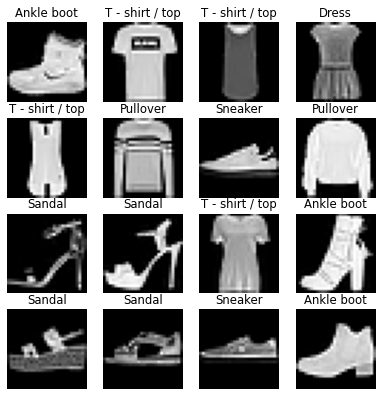

In [94]:
show_images(x_batch[:16], imsize=1.7, titles=titles)

In [95]:
learning_rate = 0.4

In [96]:
cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [97]:
opt = optim.SGD(cnn.parameters(), lr=learning_rate)
loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.7353272417068482 0.7276
1 0.5485773526668548 0.8015
2 0.4763732698917389 0.8304
3 0.44692213354110716 0.8415
4 0.42945078554153443 0.8436


In [45]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

## Autoencoder

Aqui vamos a crear una `deconvolutional function`, que hará lo contrario de la convolution que definimos antes

In [46]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

Aquí definimos dos funciones para el `fit` que teníamos antes 

In [47]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

La diferencia es que ahora en la parte de `Loss` no se está calculando un loss con respecto a un validation set, sino que se está comparando consigo mismo, porque necesitamos entrenarlo para que recree lo que le entro, así funciona un autoencoder

In [48]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

Y Aquí definimos nuestro Autoencoder

`nn.Sigmoid` hace que todos los valores estén dentro de 0 y 1

In [49]:
autoencoder = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

In [50]:
eval(autoencoder, F.mse_loss, dv)

0 0.182


In [51]:
opt = optim.AdamW(autoencoder.parameters(), lr=0.01)
fit(5, autoencoder, F.mse_loss, opt, dt, dv)

0 0.016
1 0.014
2 0.013
3 0.013
4 0.014


In [52]:
opt = optim.SGD(autoencoder.parameters(), lr=0.1)
fit(5, autoencoder, F.mse_loss, opt, dt, dv)

0 0.013
1 0.013
2 0.013
3 0.013
4 0.013


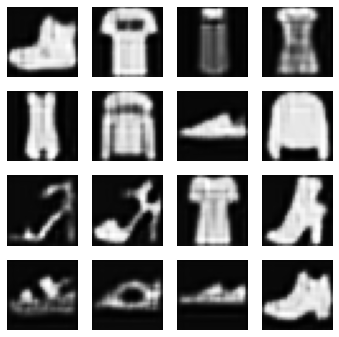

In [53]:
p = autoencoder(x_batch)
show_images(p[:16].data.cpu(), imsize=1.5)

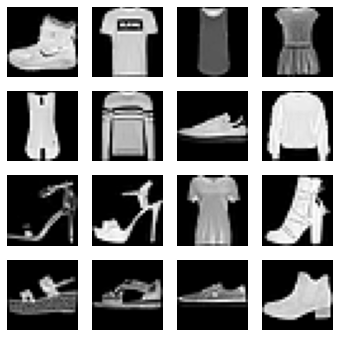

In [79]:
show_images(xb[:16].data.cpu(), imsize=1.5)